In [132]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
nlp = spacy.load('de_core_news_sm')

parties = [
    'linke',
    'grüne',
    'spd',
    'fdp',
    'cdu_csu',
    'afd',
]

media = [
    'junge Welt',
    "NachDenkSeiten",
    'taz',
    'Süddeutsche Zeitung',
    'stern TV',
    "DER SPIEGEL",
    'ZEIT ONLINE',
    'Der Tagesspiegel',
    'ARD',
    #'tagesschau',
    'ZDF',
    "ZDFheute Nachrichten",
    'Bayerischer Rundfunk',
    'ntv Nachrichten',
    'RTL',
    'FOCUS Online',
    'faz',
    'WELT',
    "BILD",
    'NZZ Neue Zürcher Zeitung',
    "Junge Freiheit",
    'COMPACTTV'
]

search_terms = {
    'cdu':['cdu', 'union'],
    'csu':['csu', 'union'],
    'fdp':['fdp', 'freien demokraten'],
    'grüne':['grünen'],
    'linke':['linke', 'linkspartei'],
    'afd':['afd', 'afg'],
    'spd':['spd', 'sozialdemokraten'],
}

df = pd.read_pickle('../data/topics_combined.pkl')
for party in search_terms.keys():
    df['contains_'+party] = [False for _ in range(len(df.index))]
    for term in search_terms[party]:
        df['contains_'+party] = df['contains_'+party] | df['preprocessed'].str.contains(term)
df['contains_party'] = df['contains_cdu'] | df['contains_csu'] | df['contains_fdp'] | df['contains_grüne'] | df['contains_linke'] | df['contains_afd'] | df['contains_spd'] 

bt = pd.read_pickle('../assets/bundestag.pkl')
bt.drop(columns=['Geburts-jahr', 'Land', 'Listen-platz', 'Erst-stimmen-anteil', 'Listen-platz', 'Wahlkreis', 'BeruflicherHintergrund', 'MdBseit', 'Bemerkungen'], inplace=True)
party_blacklist = [
    'fraktionslos(SSW)',
    'fraktionslos (Zentrum)',
    'fraktionslos (AfD)',
    'fraktionslos (ehemals AfD)',
]
bt = bt[bt['Fraktion(Partei)'].isin(party_blacklist) == False]
bt.loc[bt['Fraktion(Partei)'] == 'CDU/CSU (CDU)', 'Fraktion(Partei)'] = 'cdu'
bt.loc[bt['Fraktion(Partei)'] == 'CDU/CSU (CSU)', 'Fraktion(Partei)'] = 'csu'
politician_dict = bt.set_index('Name').to_dict()['Fraktion(Partei)']
politicians = {
    politician.lower():politician_dict[politician].lower() for politician in list(politician_dict.keys())
}

In [80]:
politicians

{'sanae abdi': 'spd',
 'valentin abel': 'fdp',
 'knut abraham': 'cdu',
 'katja adler': 'fdp',
 'stephanie aeffner': 'grüne',
 'adis ahmetovic': 'spd',
 'gökay akbulut': 'linke',
 'reem alabali-radovan': 'spd',
 'stephan albani': 'cdu',
 'ali al-dailami': 'linke',
 'muhanad al-halak': 'fdp',
 'renata alt': 'fdp',
 'norbert altenkamp': 'cdu',
 'philipp amthor': 'cdu',
 'luise amtsberg': 'grüne',
 'dagmar andres': 'spd',
 'niels annen': 'spd',
 'johannes arlt': 'spd',
 'christine aschenberg-dugnus': 'fdp',
 'andreas audretsch': 'grüne',
 'artur auernhammer': 'csu',
 'peter aumer': 'csu',
 'maik außendorf': 'grüne',
 'tobias b. bacherle': 'grüne',
 'carolin bachmann': 'afd',
 'lisa badum': 'grüne',
 'heike baehrens': 'spd',
 'dorothee bär': 'csu',
 'karl bär': 'grüne',
 'annalena baerbock': 'grüne',
 'ulrike bahr': 'spd',
 'daniel baldy': 'spd',
 'felix banaszak': 'grüne',
 'nezahat baradari': 'spd',
 'thomas bareiß': 'cdu',
 'sören bartol': 'spd',
 'dietmar bartsch': 'linke',
 'bärbel bas

In [81]:
def standardize_df(input_df):
    df = input_df.copy()
    for party in df.columns:
        df[party] -= df[party].mean()
    return df.round(3)

In [82]:
def columnwise_percentage(input_df):
    df = input_df.copy()
    for medium in df.columns:
        df[medium] /= df[medium].sum()
    return df.round(3)

In [83]:
mentions_by_media = df.groupby(['medium'])[['contains_linke', 'contains_grüne', 'contains_spd', 'contains_fdp', 'contains_csu', 'contains_cdu', 'contains_afd']].sum()
mentions_by_media = mentions_by_media.loc[media].transpose()
mentions_by_media.index = [['linke', 'grüne', 'spd', 'fdp', 'csu', 'cdu', 'afd']]

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'percentage of mentions by medium y\nthat are about party x\nstandardized across media')]

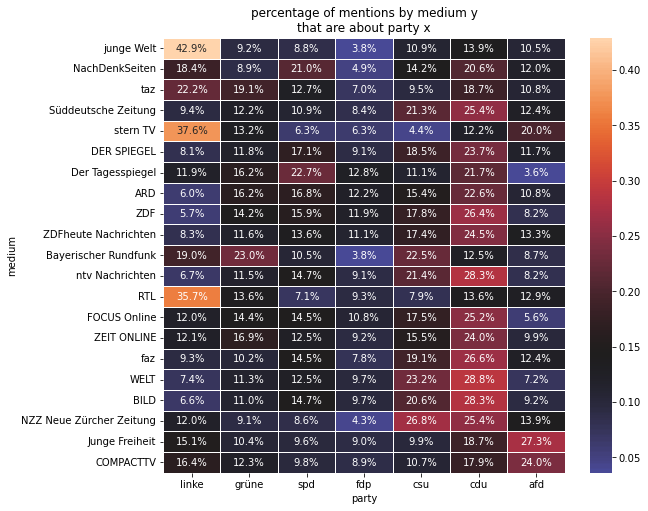

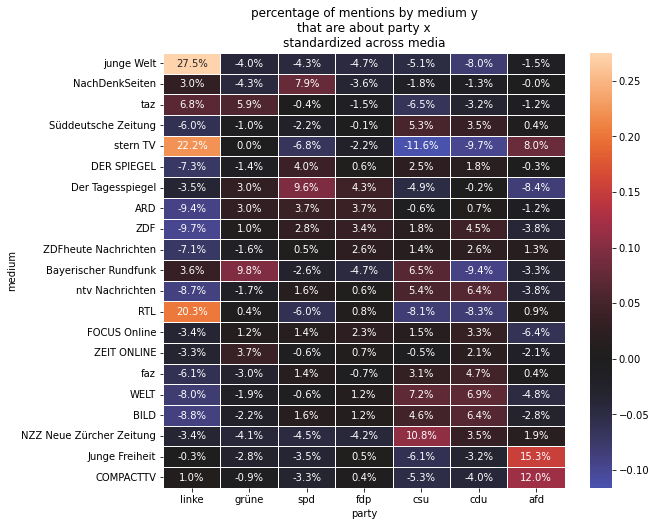

In [84]:
df_to_plot = columnwise_percentage(mentions_by_media).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, fmt=".1%", linewidths=.5, ax=ax, center=np.nanmean(df_to_plot))
ax.set(xlabel='party', ylabel='medium', title='percentage of mentions by medium y\nthat are about party x')

df_to_plot = standardize_df(columnwise_percentage(mentions_by_media).transpose())
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, fmt=".1%", linewidths=.5, ax=ax, center=np.nanmean(df_to_plot))
ax.set(xlabel='party', ylabel='medium', title='percentage of mentions by medium y\nthat are about party x\nstandardized across media')

In [85]:
stats_df = columnwise_percentage(mentions_by_media).transpose()
print(f"party mentions means:\n{stats_df.mean()}\n\nparty mentions standard deviation:\n{stats_df.std()}")

party mentions means:
linke    0.153714
grüne    0.131571
spd      0.130857
fdp      0.085286
csu      0.159810
cdu      0.218571
afd      0.120286
dtype: float64

party mentions standard deviation:
linke    0.108471
grüne    0.035420
spd      0.042308
fdp      0.026766
csu      0.058053
cdu      0.053650
afd      0.056582
dtype: float64


In [86]:
'''scaler = StandardScaler()
mentions_by_media_scaled = mentions_by_media.copy(deep=True)
mentions_by_media_scaled = pd.DataFrame(scaler.fit_transform(mentions_by_media_scaled), columns=mentions_by_media_scaled.columns, index=mentions_by_media_scaled.index).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(mentions_by_media_scaled, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='party mentions by media source, standard scaling')'''

'scaler = StandardScaler()\nmentions_by_media_scaled = mentions_by_media.copy(deep=True)\nmentions_by_media_scaled = pd.DataFrame(scaler.fit_transform(mentions_by_media_scaled), columns=mentions_by_media_scaled.columns, index=mentions_by_media_scaled.index).transpose()\nf, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(mentions_by_media_scaled, annot=True, fmt=".2", linewidths=.5, ax=ax)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'party mentions by media source, standard scaling\')'

In [87]:
for party in list(set(politicians.values())):
    df['politician_count_'+party] = [0 for _ in range(df.shape[0])]

for politician in tqdm(politicians.keys()):
    df['politician_count_'+politicians[politician]] += df['preprocessed'].str.contains(politician)

politician_mentions_by_media = df.groupby(['medium'])[['politician_count_linke', 'politician_count_grüne', 'politician_count_spd', 'politician_count_fdp', 'politician_count_csu', 'politician_count_cdu', 'politician_count_afd']].sum()
politician_mentions_by_media = politician_mentions_by_media.loc[media].transpose()
politician_mentions_by_media.index = [['linke', 'grüne', 'spd', 'fdp', 'csu', 'cdu', 'afd']]

100%|██████████| 731/731 [06:13<00:00,  1.96it/s]


In [88]:
'''scaler = StandardScaler()
politician_mentions_by_media_scaled = politician_mentions_by_media.copy(deep=True)
politician_mentions_by_media_scaled = pd.DataFrame(scaler.fit_transform(politician_mentions_by_media_scaled), columns=politician_mentions_by_media_scaled.columns, index=politician_mentions_by_media_scaled.index).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(politician_mentions_by_media_scaled, annot=True, fmt=".2", linewidths=.5, ax=ax)
ax.set(xlabel='party', ylabel='medium', title='politician mentions by media source, standard scaling')'''

'scaler = StandardScaler()\npolitician_mentions_by_media_scaled = politician_mentions_by_media.copy(deep=True)\npolitician_mentions_by_media_scaled = pd.DataFrame(scaler.fit_transform(politician_mentions_by_media_scaled), columns=politician_mentions_by_media_scaled.columns, index=politician_mentions_by_media_scaled.index).transpose()\nf, ax = plt.subplots(figsize=(9, 8))\nsns.heatmap(politician_mentions_by_media_scaled, annot=True, fmt=".2", linewidths=.5, ax=ax)\nax.set(xlabel=\'party\', ylabel=\'medium\', title=\'politician mentions by media source, standard scaling\')'

[Text(0.5, 51.0, 'party'),
 Text(59.99999999999999, 0.5, 'medium'),
 Text(0.5, 1.0, 'percentage of mentions by medium y\nthat are about politicians of party x\nstandardized across media')]

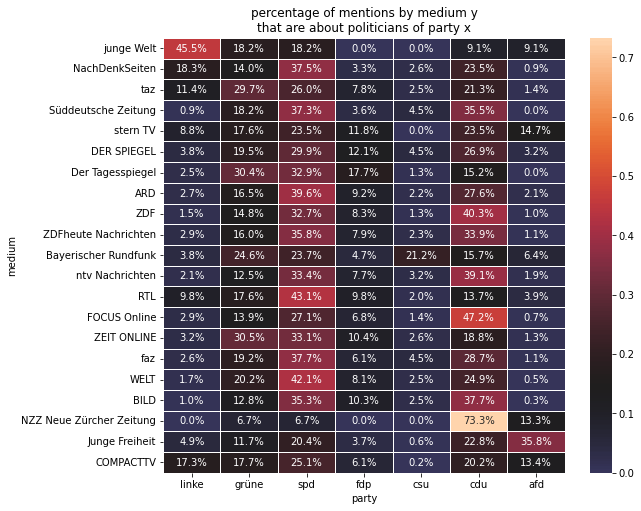

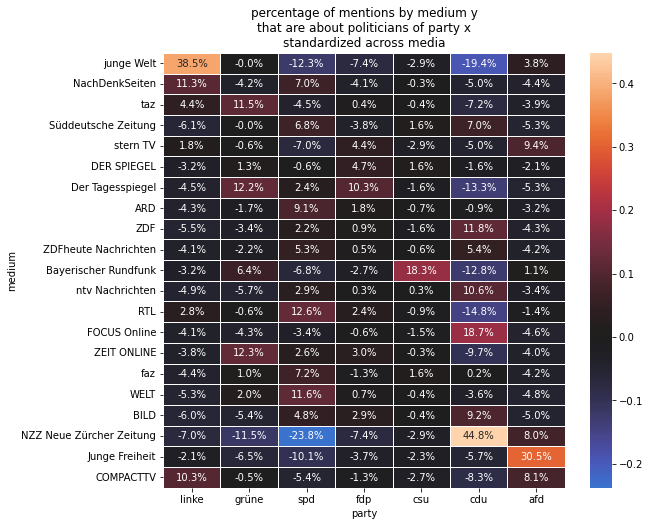

In [90]:
df_to_plot = columnwise_percentage(politician_mentions_by_media).transpose()
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, fmt=".1%", linewidths=.5, ax=ax, center=np.nanmean(df_to_plot))
ax.set(xlabel='party', ylabel='medium', title='percentage of mentions by medium y\nthat are about politicians of party x')

df_to_plot = standardize_df(columnwise_percentage(politician_mentions_by_media).transpose())
f, ax = plt.subplots(figsize=(9, 8))
sns.heatmap(df_to_plot, annot=True, fmt=".1%", linewidths=.5, ax=ax, center=np.nanmean(df_to_plot))
ax.set(xlabel='party', ylabel='medium', title='percentage of mentions by medium y\nthat are about politicians of party x\nstandardized across media')

In [91]:
stats_df = columnwise_percentage(politician_mentions_by_media).transpose()
print(f"politician mentions means:\n{stats_df.mean()}\n\npolitician mentions standard deviation:\n{stats_df.std()}")

politician mentions means:
linke    0.070286
grüne    0.182048
spd      0.305286
fdp      0.074000
csu      0.029476
cdu      0.285190
afd      0.053381
dtype: float64

politician mentions standard deviation:
linke    0.102031
grüne    0.062152
spd      0.088781
fdp      0.041306
csu      0.044165
cdu      0.141791
afd      0.084313
dtype: float64


In [153]:
columnwise_percentage(mentions_by_media.loc[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]).transpose().loc[media].to_pickle('../data/mentions/party.pkl')
standardize_df(columnwise_percentage(mentions_by_media.loc[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]).transpose().loc[media]).to_pickle('../data/mentions/party_standardized.pkl')
columnwise_percentage(politician_mentions_by_media.loc[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]).transpose().loc[media].to_pickle('../data/mentions/politician.pkl')
standardize_df(columnwise_percentage(politician_mentions_by_media.loc[['linke', 'grüne', 'spd', 'fdp', 'cdu', 'csu', 'afd']]).transpose().loc[media]).to_pickle('../data/mentions/politician_standardized.pkl')